In [1]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib as plt

In [2]:
from pycaret.anomaly import *

## 1. Lectura base de datos

In [109]:
data_path = r"D:\DANE - Contrato\2024\Operativo Barrido\Data"
emicron = pd.read_csv(os.path.join(data_path,"emicron_establecimientos.csv"),header = 0)
emicron = emicron[emicron['OLA']==2022].reset_index(drop=True)
emicron.drop('OLA',axis=1,inplace=True)

In [94]:
emicron.head()

,id,VENTAS_MES_ANTERIOR,POTTOT,REMUNERACION_TOTAL,CYG,COD_DEPTO,CPAM,GRUPOS4,UBICA,IDRUT,REG_CONT,CAMCOMER
0,212002411,2000000,0.0,0.0,1110000,8,0,4,1,0,3,0
1,212003711,1950000,0.0,0.0,1152000,8,0,4,3,0,4,0
2,212003812,5600000,1.0,400000.0,4200000,8,0,4,3,0,4,0
3,212007611,2940000,1.0,0.0,2090000,8,0,3,3,0,4,0
4,212008611,20000000,1.0,600000.0,9779000,8,0,3,1,1,4,1


### Librería pycaret

In [95]:
emicron.set_index('id',inplace = True, drop = True)

emicron_data = setup(emicron,
                     categorical_features= ['COD_DEPTO','GRUPOS4', 'UBICA','REG_CONT'],
                   session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(22782, 11)"
2,Transformed data shape,"(22782, 40)"
3,Numeric features,7
4,Categorical features,4
5,Preprocess,True
6,Imputation type,simple
7,Numeric imputation,mean
8,Categorical imputation,mode
9,Maximum one-hot encoding,-1


In [96]:
emicron_data.dataset_transformed.columns

Index(['VENTAS_MES_ANTERIOR', 'POTTOT', 'REMUNERACION_TOTAL', 'CYG',
       'COD_DEPTO_8.0', 'COD_DEPTO_13.0', 'COD_DEPTO_44.0', 'COD_DEPTO_47.0',
       'COD_DEPTO_70.0', 'COD_DEPTO_20.0', 'COD_DEPTO_25.0', 'COD_DEPTO_11.0',
       'COD_DEPTO_18.0', 'COD_DEPTO_41.0', 'COD_DEPTO_15.0', 'COD_DEPTO_68.0',
       'COD_DEPTO_54.0', 'COD_DEPTO_76.0', 'COD_DEPTO_52.0', 'COD_DEPTO_19.0',
       'COD_DEPTO_17.0', 'COD_DEPTO_63.0', 'COD_DEPTO_73.0', 'COD_DEPTO_66.0',
       'COD_DEPTO_5.0', 'COD_DEPTO_23.0', 'COD_DEPTO_27.0', 'COD_DEPTO_50.0',
       'COD_DEPTO_88.0', 'CPAM', 'GRUPOS4_4.0', 'GRUPOS4_3.0', 'GRUPOS4_2.0',
       'UBICA', 'IDRUT', 'REG_CONT_3.0', 'REG_CONT_4.0', 'REG_CONT_2.0',
       'REG_CONT_1.0', 'CAMCOMER'],
      dtype='object')

In [97]:
iforest = create_model('iforest',  max_features = 25, n_estimators = 1000)
print(iforest)

IForest(behaviour='new', bootstrap=False, contamination=0.05, max_features=25,
    max_samples='auto', n_estimators=1000, n_jobs=-1, random_state=123,
    verbose=0)


In [98]:
iforest_results = assign_model(iforest)
iforest_results.head()

,VENTAS_MES_ANTERIOR,POTTOT,REMUNERACION_TOTAL,CYG,COD_DEPTO,CPAM,GRUPOS4,UBICA,IDRUT,REG_CONT,CAMCOMER,Anomaly,Anomaly_Score
id,,,,,,,,,,,,,
212002411,2000000,0.0,0.0,1110000,8,0,4,1,0,3,0,0,-0.052609
212003711,1950000,0.0,0.0,1152000,8,0,4,3,0,4,0,0,-0.065853
212003812,5600000,1.0,400000.0,4200000,8,0,4,3,0,4,0,0,-0.039601
212007611,2940000,1.0,0.0,2090000,8,0,3,3,0,4,0,0,-0.059298
212008611,20000000,1.0,600000.0,9779000,8,0,3,1,1,4,1,0,-0.014760


In [99]:
iforest_results['Anomaly'].value_counts()

0    21642
1     1140
Name: Anomaly, dtype: int64

<AxesSubplot:xlabel='CYG', ylabel='VENTAS_MES_ANTERIOR'>

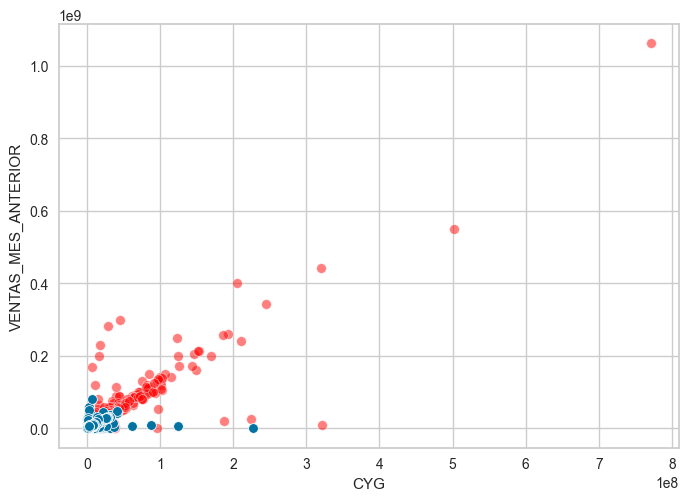

In [100]:
sns.scatterplot(x="CYG", y='VENTAS_MES_ANTERIOR', data= iforest_results[iforest_results['Anomaly']==1],color='red', alpha = 0.5)
sns.scatterplot(x="CYG", y='VENTAS_MES_ANTERIOR', data= iforest_results[iforest_results['Anomaly']==0])

<AxesSubplot:xlabel='REMUNERACION_TOTAL', ylabel='VENTAS_MES_ANTERIOR'>

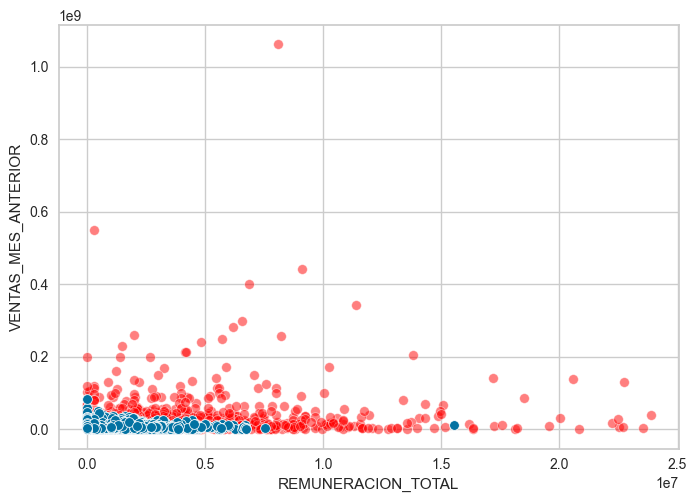

In [101]:
sns.scatterplot(x="REMUNERACION_TOTAL", y='VENTAS_MES_ANTERIOR', data= iforest_results[iforest_results['Anomaly']==1],color='red', alpha = 0.5)
sns.scatterplot(x="REMUNERACION_TOTAL", y='VENTAS_MES_ANTERIOR', data= iforest_results[iforest_results['Anomaly']==0])

### Librería scikit-learn

In [16]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder

#### One-hot encoding

In [110]:
emicron_ohe = emicron.copy()

ohe_dpto = OneHotEncoder().fit(emicron_ohe[['COD_DEPTO']])
drop_enc = ohe_dpto.transform(emicron_ohe[['COD_DEPTO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_dpto.get_feature_names_out())
#drop_enc_df.drop('COD_DEPTO_5', axis=1, inplace = True) # Utilizar como categoría de referencia 5: Antioquia

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_ubi = OneHotEncoder().fit(emicron_ohe[['UBICA']])
drop_enc = ohe_ubi.transform(emicron_ohe[['UBICA']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_ubi.get_feature_names_out())
drop_enc_df.drop('UBICA_3', axis=1, inplace = True)  # Utilizar como categoría de referencia 3: Vivienda (aplica sólo para Establecimientos)

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_sector = OneHotEncoder().fit(emicron_ohe[['GRUPOS4']])
drop_enc = ohe_sector.transform(emicron_ohe[['GRUPOS4']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_sector.get_feature_names_out())
#drop_enc_df.drop('GRUPOS4_2', axis=1, inplace = True) # Utilizar como categoría de referencia 2: Industria Manufacturera

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_conta = OneHotEncoder().fit(emicron_ohe[['REG_CONT']])
drop_enc = ohe_conta.transform(emicron_ohe[['REG_CONT']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_conta.get_feature_names_out())
#drop_enc_df.drop('REG_CONT_4', axis=1, inplace = True) # Utilizar como categoría de referencia 4: No lleva registros (aplica sólo para Establecimientos)

emicron_ohe = emicron_ohe.join(drop_enc_df)

In [111]:
emicron_ohe.drop(['COD_DEPTO','UBICA','GRUPOS4','REG_CONT'],axis=1, inplace= True) 
emicron_ohe.set_index('id',inplace = True, drop = True)

In [112]:
Iforest = IsolationForest(max_samples='auto', 
                          random_state = 123,
                          contamination=0.05,
                          max_features= 25,
                          n_estimators=1000,
                          verbose=1,
                          n_jobs=-1)
Iforest.fit(emicron_ohe)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.1s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished


IsolationForest(contamination=0.05, max_features=25, n_estimators=1000,
                n_jobs=-1, random_state=123, verbose=1)

In [114]:
y_pred = Iforest.predict(emicron_ohe)
y_pred_adjusted = [1 if x == -1 else 0 for x in y_pred]
sum(y_pred_adjusted)

1140

In [121]:
score = Iforest.score_samples(emicron_ohe)

In [122]:
Iforest.decision_function(emicron_ohe)

array([0.04933412, 0.06245283, 0.0390747 , ..., 0.07023782, 0.06323436,
       0.02988711])

In [118]:
emicron['Anomaly'] = y_pred_adjusted

In [108]:
emicron[emicron['Anomaly']==1].index.isin(iforest_results[iforest_results['Anomaly']==1].index).sum()

1058

In [119]:
emicron.head()

,id,VENTAS_MES_ANTERIOR,POTTOT,REMUNERACION_TOTAL,CYG,COD_DEPTO,CPAM,GRUPOS4,UBICA,IDRUT,REG_CONT,CAMCOMER,Anomaly
0,212002411,2000000,0.0,0.0,1110000,8,0,4,1,0,3,0,0
1,212003711,1950000,0.0,0.0,1152000,8,0,4,3,0,4,0,0
2,212003812,5600000,1.0,400000.0,4200000,8,0,4,3,0,4,0,0
3,212007611,2940000,1.0,0.0,2090000,8,0,3,3,0,4,0,0
4,212008611,20000000,1.0,600000.0,9779000,8,0,3,1,1,4,1,0


In [120]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        return(df)